In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import KFold
from tensorflow.keras.backend import clear_session
from proglearn.transformers import NeuralClassificationTransformer
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.voters import MLKNNClassificationVoter
from tensorflow.keras.optimizers import Adam
from proglearn.deciders import SimpleArgmaxAverage
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
seed = 1
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [3]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.img_path_correct = ''
        self.mask_path_correct = ''
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "ISIC2018_Task1-2_Training_Input", id_name) + ".jpg"
        mask_path = os.path.join(self.path, "ISIC2018_Task1_Training_GroundTruth", id_name) + "_segmentation.png"
        
        ## Reading Image
        try:
            image = cv2.imread(image_path,1)
            image = cv2.resize(image, (self.image_size, self.image_size))
            mask = np.zeros((self.image_size, self.image_size, 1))
            _mask = cv2.imread(mask_path, -1)
            _mask = cv2.resize(_mask, (self.image_size, self.image_size))
            _mask = np.expand_dims(_mask, axis=-1)
            mask = np.maximum(mask, _mask)
            
            
            ## Normalizaing 
            image = image/255.0
            mask = mask/255.0
            self.img_path_correct = image_path
            self.mask_path_correct = mask_path
            return image, mask
        except:
            if self.img_path_correct != '':
                image = cv2.imread(self.img_path_correct,1)
                
                image = cv2.resize(image, (self.image_size, self.image_size))
                image = cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
                mask = np.zeros((self.image_size, self.image_size, 1))
                
                _mask = cv2.imread(self.mask_path_correct, -1)
                _mask = cv2.resize(_mask, (self.image_size, self.image_size))
                _mask = np.expand_dims(_mask, axis=-1)
                mask = np.maximum(mask, _mask)
                mask = cv2.rotate(mask, cv2.cv2.ROTATE_90_CLOCKWISE)
                
                
                ## Normalizaing 
                image = image/255.0
                mask = mask/255.0
                return image, mask
            else:
                image = np.ones((self.image_size, self.image_size))
                mask = np.ones((self.image_size, self.image_size))
                ## Normalizaing 
                image = image/255.0
                mask = mask/255.0
                
                return image, mask

    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = tf.convert_to_tensor(image)
        mask  = tf.convert_to_tensor(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [4]:
image_size = 128
path = "./"
train_path = "./ISIC2018_Task1-2_Training_Input"

## Training Ids
train_ids = []
for files in os.walk(train_path):
   for name in files:
      train_ids.append(name)

train_ids = train_ids[2]
ids = [i.split('.', 1)[0] for i in train_ids]

def get_images(data_path, ids, image_size):
    images = np.zeros((len(ids), image_size, image_size, 3))
    masks = np.zeros((len(ids), image_size, image_size, 1))

    for i, id_name in enumerate(ids):
        image_path = os.path.join(data_path, "ISIC2018_Task1-2_Training_Input", id_name) + ".jpg"
        mask_path = os.path.join(data_path, "ISIC2018_Task1_Training_GroundTruth", id_name) + "_segmentation.png"
        image = cv2.imread(image_path,1)
        image = cv2.resize(image, (image_size, image_size))
        mask = np.zeros((image_size, image_size, 1))
        _mask = cv2.imread(mask_path, -1)
        _mask = cv2.resize(_mask, (image_size, image_size))
        _mask = np.expand_dims(_mask, axis=-1)
        mask = np.maximum(mask, _mask)
        
        
        ## Normalizaing 
        images[i,:,:,:] = image/255.0
        masks[i,:,:,:] = np.rint(mask/255.0)
    return images, masks

In [5]:
x, y = get_images(path, ids[:20], image_size)

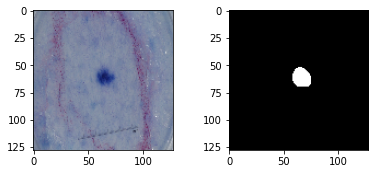

In [6]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(np.rint(y[r]), (image_size, image_size)), cmap="gray")

In [7]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [8]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) 
    c2, p2 = down_block(p1, f[1]) 
    c3, p3 = down_block(p2, f[2])
    c4, p4 = down_block(p3, f[3]) 
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [9]:
def dice(seg, gt):
    intersection = tf.reduce_sum(tf.cast(tf.equal(seg, gt), tf.float32))
    return intersection * 2.0 / tf.cast(tf.size(seg) + tf.size(gt), tf.float32)


In [10]:
# hyperparameters

num_tasks = 10
batch_size = 50
network_batch_size = 10
test_batch_size = batch_size // num_tasks

In [13]:
accuracies = np.full((num_tasks + 1, num_tasks, num_tasks), np.nan)

random.shuffle(ids)

data_ids = ids[:(num_tasks+1) * batch_size]
kf = KFold(n_splits=num_tasks+1)
for i, (train_index, test_index) in enumerate(kf.split(data_ids)):
    train_ids = [data_ids[i] for i in train_index]
    test_ids = [data_ids[i] for i in test_index]

    for task in range(0, num_tasks):
        print(f"Experiment {i}; Task {task}")
        clear_session()

        network = UNet()
        transformer = NeuralClassificationTransformer

        kwargs = {
                "network": network,
                "euclidean_layer_idx": -1,
                "loss": "categorical_crossentropy",
                "optimizer": Adam(1e-3),
                "fit_kwargs": {
                    "epochs": 100,
                    "callbacks": [EarlyStopping(patience=5, monitor="val_loss")],
                    "verbose": False,
                    "validation_split": 0.33,
                    "batch_size": network_batch_size,
                },
            }
        voter = MLKNNClassificationVoter

        learner = ProgressiveLearner(
                default_transformer_class=transformer,
                default_transformer_kwargs=kwargs,
                default_voter_class=voter
            )


        X_train, Y_train = get_images(path, train_ids[task * batch_size:(task + 1)*batch_size], image_size)
        learner.add_task(
                    X=X_train,
                    y=Y_train,
                    task_id=task,
                    num_transformers=1,
                    transformer_voter_decider_split=[0.67, 0.33, 0],
                    decider_kwargs={
                        "classes": np.unique(Y_train)
                    },
                )
        
        for t in range(task):
            X_test, Y_test = get_images(path, test_ids[t*test_batch_size:(t+1)*test_batch_size])
            prediction = learner.predict(
                X_test,
                task_id=t
            )
            accuracies[i][task][t] = np.mean(Y_test == prediction)

            X_train, Y_train = get_images(path, train_ids[t * batch_size:(t + 1)*batch_size], image_size)

            learner.add_task(
                    X=X_train,
                    y=Y_train,
                    task_id=t,
                    num_transformers=1,
                    transformer_voter_decider_split=[0.67, 0.33, 0],
                    decider_kwargs={
                        "classes": np.unique(Y_train)
                    },
                )
        
        X_test, Y_test = get_images(path, test_ids[task*test_batch_size:(task+1)*test_batch_size])
        prediction = learner.predict(
            X_test,
            task_id=task
        )

        accuracies[i][task][task] = np.mean(Y_test == prediction)

        for t in range(task+1, num_tasks):
            X_test, Y_test = get_images(path, test_ids[t*test_batch_size:(t+1)*test_batch_size])
            prediction = learner.predict(
                X_test,
                task_id=t
            )
            accuracies[i][task][t] = np.mean(Y_test == prediction)

            X_train, Y_train = get_images(path, train_ids[t * batch_size:(t + 1)*batch_size], image_size)

            learner.add_task(
                    X=X_train,
                    y=Y_train,
                    task_id=t,
                    num_transformers=1,
                    transformer_voter_decider_split=[0.67, 0.33, 0],
                    decider_kwargs={
                        "classes": np.unique(Y_train)
                    },
                )

Experiment 0; Task 0


ValueError: in user code:

    /home/krao/anaconda3/envs/ProgLearn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/krao/anaconda3/envs/ProgLearn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/krao/anaconda3/envs/ProgLearn/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/krao/anaconda3/envs/ProgLearn/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/krao/anaconda3/envs/ProgLearn/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/krao/anaconda3/envs/ProgLearn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/krao/anaconda3/envs/ProgLearn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:748 train_step
        loss = self.compiled_loss(
    /home/krao/anaconda3/envs/ProgLearn/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/krao/anaconda3/envs/ProgLearn/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /home/krao/anaconda3/envs/ProgLearn/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/krao/anaconda3/envs/ProgLearn/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/krao/anaconda3/envs/ProgLearn/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /home/krao/anaconda3/envs/ProgLearn/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/krao/anaconda3/envs/ProgLearn/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/krao/anaconda3/envs/ProgLearn/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 128, 128, 1) are incompatible


In [ ]:
accuracies = np.mean(accuracies, axis=0)

fte = [(1 - accuracies[t][0])/(1 - accuracies[t][t]) for t in range(num_tasks)]
bte = [[(1 - accuracies[t][t])/(1 - accuracies[t][k]) for k in range(t, num_tasks)] for t in range(num_tasks)]
te = [[fte[t] / bte[t][k] for k in range(len(bte[t]))] for t in range(num_tasks)]

In [ ]:
plt.figure()
ax, fig = plt.subplots(2, 2, figsize=(16, 11.5))

# fte
ax[0][0].plot(np.arange(1, num_tasks + 1), fte)
ax[0][0].set_xlabel("Number of tasks seen")
ax[0][0].set_ylabel("FTE")

# bte
for t in range(num_tasks):
    ax[0][1].plot(np.arange(t+1, num_tasks+1), np.array(bte[t]))
ax[0][1].set_xlabel("Number of tasks seen")
ax[0][1].set_ylabel("BTE")

# te
for t in range(num_tasks):
    ax[0][1].plot(np.arange(t+1, num_tasks+1), np.array(te[t]))
ax[1][0].set_xlabel("Number of tasks seen")
ax[1][0].set_ylabel("TE")

# accuracy
for t in range(num_tasks):
    ax[0][1].plot(np.arange(t+1, num_tasks+1), np.array(accuracies[t][t:]))
ax[1][0].set_xlabel("Number of tasks seen")
ax[1][0].set_ylabel("Accuracy")